In [112]:
import pandas as pd
import os
import joblib
from keras.src.layers import TextVectorization, LayerNormalization, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import parallel_backend
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import (
    Embedding, GlobalMaxPooling1D, Attention, Input, LSTM, Bidirectional, Dense, MultiHeadAttention, LayerNormalization, Dropout, Conv1D, MaxPooling1D, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_hub
from sklearn.cluster import KMeans

In [113]:
# load in the data
human = pd.read_csv('Data/human_final.csv')
thaliana = pd.read_csv('Data/ara_tha_final.csv')
mouse = pd.read_csv('Data/ara_tha_final.csv')


In [114]:
# adding a species column and promoter_status column
human['Species'] = 'Human'
thaliana['Species'] = 'Thaliana'
mouse['Species'] = 'Mouse'
human['Promoter Status'] = human['Promoter ID'].str.contains('FP')
thaliana['Promoter Status'] = thaliana['Promoter ID'].str.contains('FP')
mouse['Promoter Status'] = mouse['Promoter ID'].str.contains('FP')
combined_data = pd.concat([human, thaliana, mouse], axis=0)
combined_data['Lengths'] = combined_data['Sequence'].str.len()

<Axes: xlabel='Species', ylabel='Lengths'>

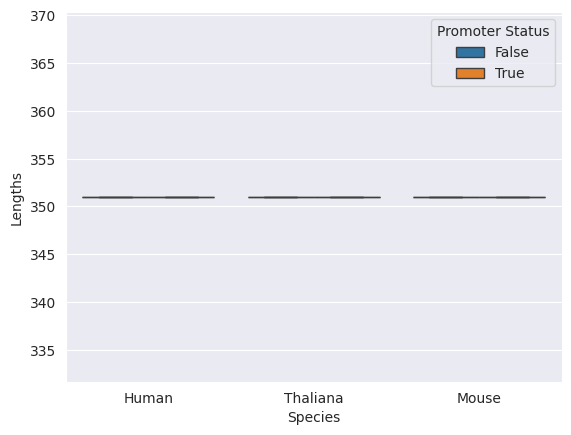

In [115]:
# plotting the lengths of the sequences
sns.boxplot(data=combined_data, y='Lengths', x='Species', hue='Promoter Status')

In [116]:
# getting the counts of each prompoter stats by species
min_group_size = combined_data.groupby(['Species', 'Promoter Status']).size().min()
# limiting the number of samples to the smallest group size
combined_data = combined_data.groupby(['Species', 'Promoter Status']).apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)
combined_data.groupby(['Species', 'Promoter Status']).size()

/tmp/ipykernel_15331/1848128409.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_data = combined_data.groupby(['Species', 'Promoter Status']).apply(lambda x: x.sample(min_group_size)).reset_index(drop=True)


Species   Promoter Status
Human     False              12944
          True               12944
Mouse     False              12944
          True               12944
Thaliana  False              12944
          True               12944
dtype: int64

In [117]:
# creating a dict that contains the train, test split for each species as well as combined data
train_test_splits = {}
for species in combined_data['Species'].unique():
    species_data = combined_data[combined_data['Species'] == species]
    train_test_splits[species]= {}
    train_test_splits[species]['x_train'], train_test_splits[species]['x_test'],train_test_splits[species]['y_train'], train_test_splits[species]['y_test'] =  train_test_split(species_data['Sequence'], species_data['Promoter Status'], test_size=0.2)
train_test_splits['Combined'] = {}
train_test_splits['Combined']['x_train'] = pd.concat([train_test_splits[species]['x_train'] for species in combined_data['Species'].unique()], axis=0)
train_test_splits['Combined']['x_test'] = pd.concat([train_test_splits[species]['x_test'] for species in combined_data['Species'].unique()], axis=0)
train_test_splits['Combined']['y_train'] = pd.concat([train_test_splits[species]['y_train'] for species in combined_data['Species'].unique()], axis=0)
train_test_splits['Combined']['y_test'] = pd.concat([train_test_splits[species]['y_test'] for species in combined_data['Species'].unique()], axis=0)


### Setting KmerVectorizer for the rest of the notebook

In [118]:
class KmerVectorizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to vectorize k-mers for different K values.
    """
    def __init__(self, K=3):
        self.K = K
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer='char', ngram_range=(self.K, self.K))
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X)

def tokenize_kmers(sequences, k):
    """Tokenize DNA sequences into k-mers."""
    kmers_list = []
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmers_list.append(kmers)
    return kmers_list

def build_kmer_tokenizer(sequences, k):
    """Fit a tokenizer on k-mer sequences."""
    kmers = tokenize_kmers(sequences, k)
    flat_kmers = [' '.join(kmer_seq) for kmer_seq in kmers]  # Flatten into space-separated strings
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(flat_kmers)
    return tokenizer

def tokenize_and_pad_kmers(sequences, tokenizer, k, max_length):
    """Convert sequences to k-mers, tokenize them, and pad them."""
    kmers = tokenize_kmers(sequences, k)
    flat_kmers = [' '.join(kmer_seq) for kmer_seq in kmers]
    sequences_tokenized = tokenizer.texts_to_sequences(flat_kmers)
    sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences_tokenized, maxlen=max_length)
    return sequences_padded

### Setting up an evaluation function for the rest of notebook

In [119]:
def evaluate_model(best_model, X_test, y_test, model_name, attention=False, max_length=None, tokenizer=None, k=5):
    print(f"Evaluating {model_name} on test data...")

    # Check if model is a Keras model
    if isinstance(best_model, tf.keras.Model):
        # Convert X_test to a tf.Tensor with dtype=tf.string
        if not attention:
            X_test_tensor = tf.constant(X_test, dtype=tf.string)
        else:
            X_test_tokenized = X_test.apply(lambda x: dna_tokenizer(x, max_length=max_length))
            X_test_tensor = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized, maxlen=max_length)
        # Get predicted probabilities
        y_prob = best_model.predict(X_test_tensor).flatten()
        y_prob = y_prob.astype(np.float64)
        # normalize between 0 and 1
    else:
        # For scikit-learn models
        if hasattr(best_model, "predict_proba"):
            y_prob = best_model.predict_proba(X_test)[:, 1]
        else:
            y_prob = best_model.predict(X_test)

    # Convert y_test and y_prob to NumPy arrays if they aren't already
    y_test = np.array(y_test)
    y_prob = np.array(y_prob)

    y_pred = (y_prob > 0.5).astype(int)

    # Compute metrics with the best threshold
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    }

    # Print results
    print(f"Results for {model_name}:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1']:.2f}")

    # Save the metrics
    results = pd.DataFrame(metrics, index=[0])
    results.to_csv(f'{model_name}_metrics.csv', index=False)

    # Visualize distribution of probabilities
    print(np.unique(y_test, return_counts=True))
    print(np.unique(y_pred, return_counts=True))
    plt.hist(y_prob, bins=50)
    plt.title("Distribution of Predicted Probabilities")
    plt.show()

    # Generate ROC curve if probabilities are available
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        metrics['roc_auc'] = roc_auc

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"ROC Curve for {model_name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.savefig(f"{model_name}_roc_curve.png")
        plt.show()
        print(f"ROC curve saved as '{model_name}_roc_curve.png'")
    else:
        print("Predicted probabilities are not available; ROC curve cannot be generated.")

    print(f"Metrics for {model_name} saved as '{model_name}_metrics.csv'")
    return metrics, y_pred, y_prob

### Testing TruncatedSVD on various K values

0 0
1 0
2 0
0 1
1 1


KeyboardInterrupt: 

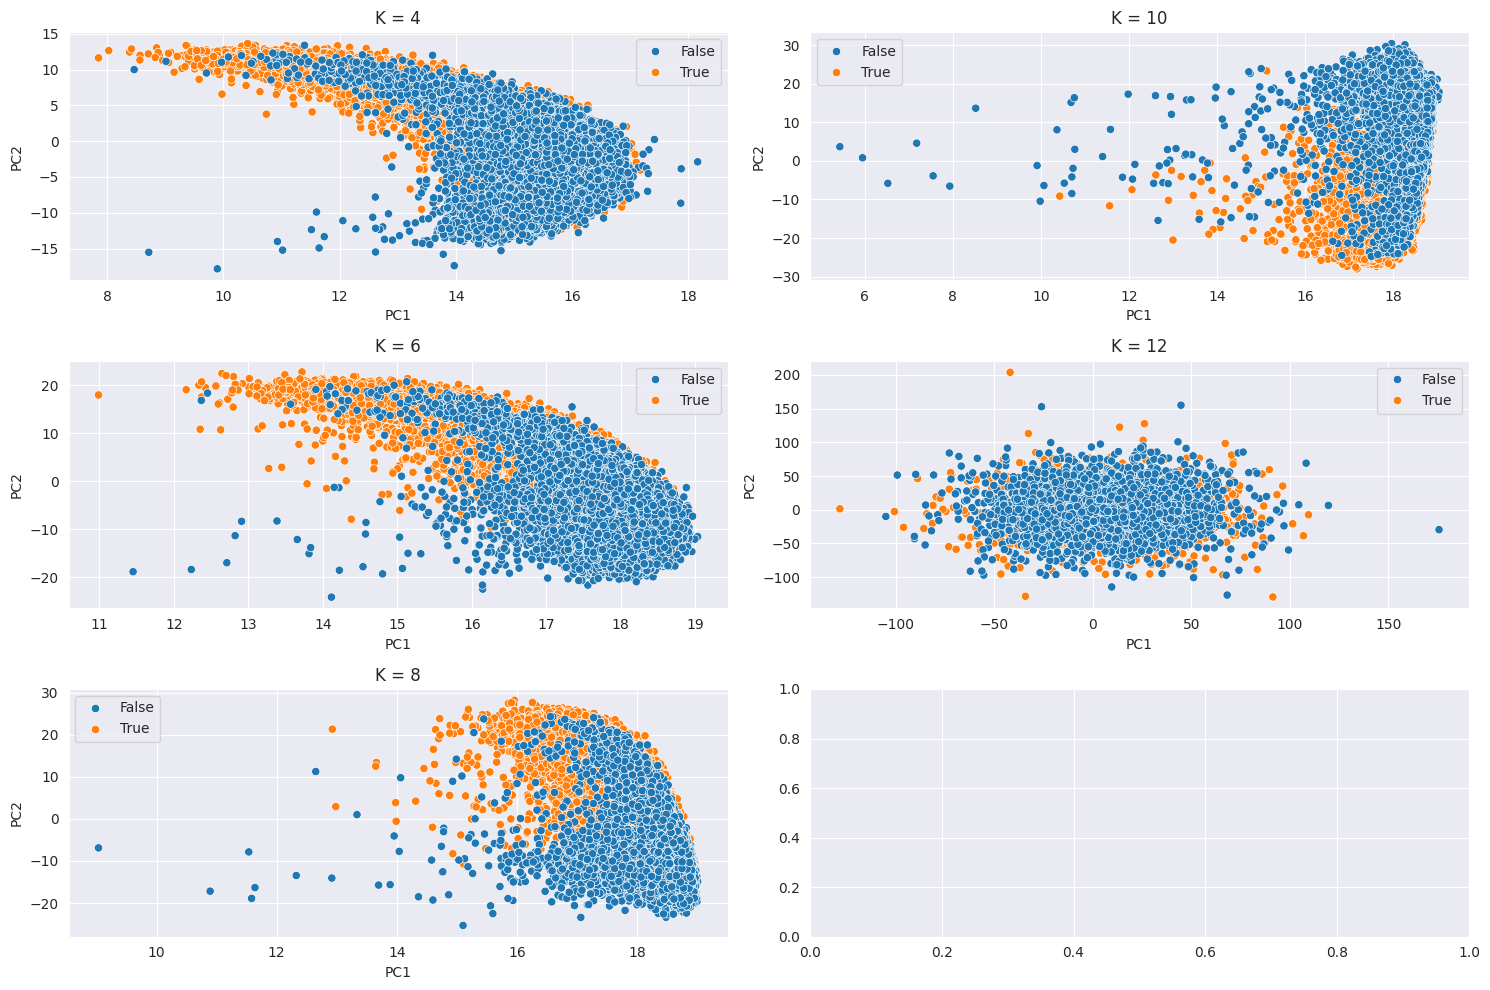

In [120]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
for i, K in enumerate([4, 6, 8, 10, 12, 14]):
    # Create pipeline
    svd_pipeline = Pipeline([
        ('kmer', KmerVectorizer(K=K)),
        ('scaler', StandardScaler(with_mean=False)),
        ('pca', TruncatedSVD(n_components=2))
    ])

    # Fit and transform the data
    X_pca = svd_pipeline.fit_transform(human['Sequence'].values)
    X_svd = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    X_svd['Promoter'] = human['Promoter Status']

    # Plot the data
    j = i // 3
    i = i % 3
    print(i, j)
    sns.scatterplot(data=X_svd, x='PC1', y='PC2', hue='Promoter', ax=ax[i, j])
    ax[i, j].set_title(f"K = {K}")
    ax[i, j].legend()
    fig.suptitle("Truncated SVD for Different K Values", fontsize=16)
    plt.tight_layout()

    plt.savefig('svd_plots.png')

## Implementing a gridsearch function for the rest of the notebook

In [36]:
def gridsearch_with_logging(X_train, y_train, model, param_grid, model_name, cv=5, scoring='accuracy', max_cpu_fraction=0.7, transform=True, load_existing=True):

    # Check if the model is already trained
    model_file = f'best_{model_name}_model.pkl'
    log_file = f'{model_name}_gridsearch_log.csv'
    if load_existing and os.path.exists(log_file):
        print(f"Model '{model_file}' already exists. Loading the model...")
        best_model = joblib.load(model_file)
        return best_model, None, None

    # Create pipeline
    if transform:
        pipeline = Pipeline([
            ('kmer', KmerVectorizer()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('model', model)
        ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,# Will be controlled by `parallel_backend`
        verbose= 4
    )

    # Custom callback for progress tracking
    current_combination = 0

    # Start grid search with resource constraints
    print(f"Starting grid search for {model_name} with up to {max_cpu_fraction * 100:.0f}% CPU usage...")

    with parallel_backend('loky', n_jobs=int(max_cpu_fraction * os.cpu_count())):
        grid_search.fit(X_train, y_train)

        # Save log
    results = pd.DataFrame(grid_search.cv_results_)
    results.to_csv(log_file, index=False)

    # Get the best model and save it
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_file)
    print(f"Best model saved as '{model_file}'")

    return best_model, grid_search.best_params_, grid_search.best_score_


### Implementing a Naive Bayes model via gridsearch, Training on Human

In [37]:
# training Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_param_grid = {
    'kmer__K': [4, 6, 8, 10],
    'model__alpha': [0.1, 0.5, 1.0],
}
x_train = train_test_splits['Human']['x_train']
y_train = train_test_splits['Human']['y_train']
best_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    x_train, y_train, nb_model, nb_param_grid, 'naive_bayes', load_existing=False
)
# displaying the best parameters and score
print("Best Parameters:", best_nb_params)


Starting grid search for naive_bayes with up to 70% CPU usage...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best model saved as 'best_naive_bayes_model.pkl'
Best Parameters: {'kmer__K': 10, 'model__alpha': 0.1}


Evaluating naive_bayes on test data...
Results for naive_bayes:
Accuracy: 0.83
Precision: 0.85
Recall: 0.80
F1 Score: 0.82
(array([False,  True]), array([2614, 2564]))
(array([0, 1]), array([2772, 2406]))


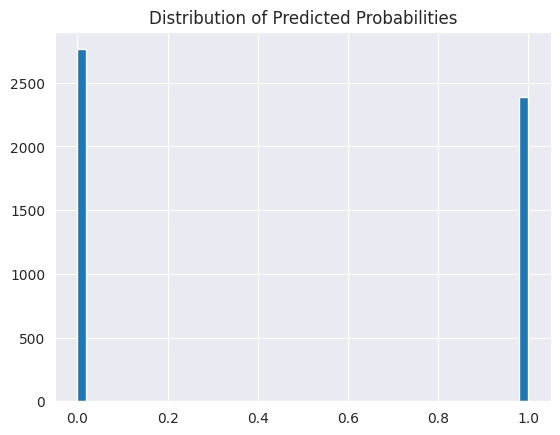

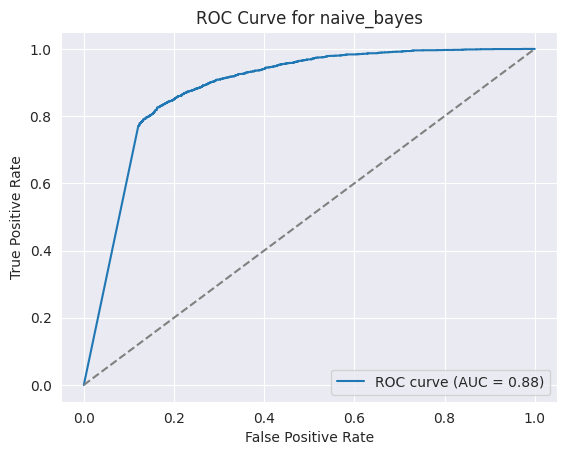

ROC curve saved as 'naive_bayes_roc_curve.png'
Metrics for naive_bayes saved as 'naive_bayes_metrics.csv'


In [38]:
# evaluating the model on human test data
x_test = train_test_splits['Human']['x_test']
y_test = train_test_splits['Human']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_human')

## Testing the Human model on Thaliana and Mouse

Evaluating naive_bayes_human_on_thaliana on test data...
Results for naive_bayes_human_on_thaliana:
Accuracy: 0.48
Precision: 0.21
Recall: 0.01
F1 Score: 0.01
(array([False,  True]), array([2541, 2637]))
(array([0, 1]), array([5087,   91]))


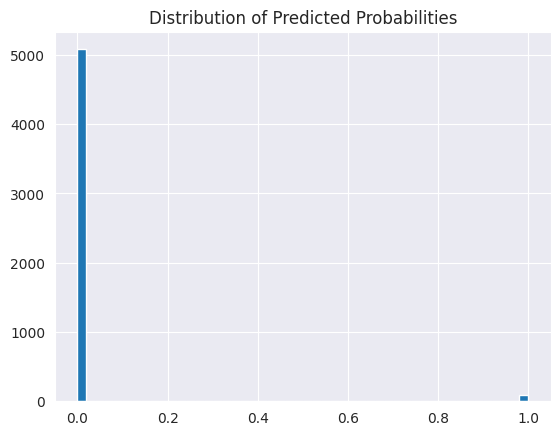

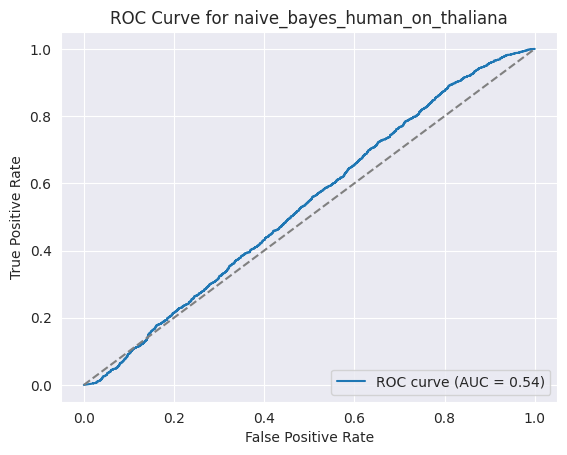

ROC curve saved as 'naive_bayes_human_on_thaliana_roc_curve.png'
Metrics for naive_bayes_human_on_thaliana saved as 'naive_bayes_human_on_thaliana_metrics.csv'
Evaluating naive_bayes_human_on_mouse on test data...
Results for naive_bayes_human_on_mouse:
Accuracy: 0.49
Precision: 0.28
Recall: 0.01
F1 Score: 0.02
(array([False,  True]), array([2579, 2599]))
(array([0, 1]), array([5075,  103]))


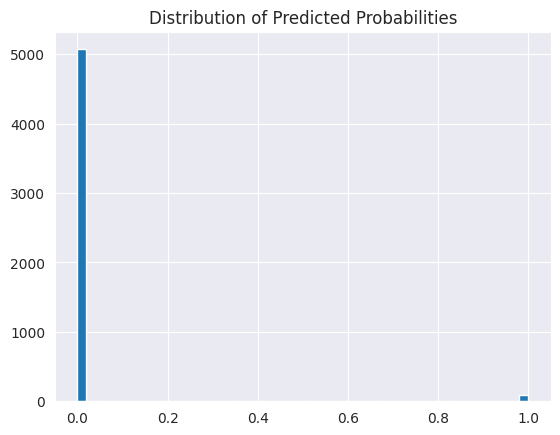

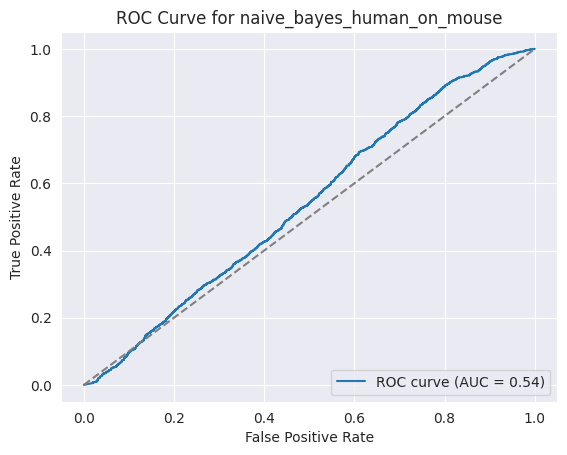

ROC curve saved as 'naive_bayes_human_on_mouse_roc_curve.png'
Metrics for naive_bayes_human_on_mouse saved as 'naive_bayes_human_on_mouse_metrics.csv'


In [39]:
# evaluating the model on thaliana test data
x_test = train_test_splits['Thaliana']['x_test']
y_test = train_test_splits['Thaliana']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_human_on_thaliana')
# evaluating the model on mouse test data
x_test = train_test_splits['Mouse']['x_test']
y_test = train_test_splits['Mouse']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_human_on_mouse')


### Training naive_bayes on combined data


In [41]:
# training Naive Bayes model
x_train = train_test_splits['Combined']['x_train']
y_train = train_test_splits['Combined']['y_train']
best_nb_model, best_nb_params, best_nb_score = gridsearch_with_logging(
    x_train, y_train, nb_model, nb_param_grid, 'naive_bayes_combined', load_existing=False
)
# displaying the best parameters and score
print("Best Parameters:", best_nb_params)

Starting grid search for naive_bayes_combined with up to 70% CPU usage...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best model saved as 'best_naive_bayes_combined_model.pkl'
Best Parameters: {'kmer__K': 10, 'model__alpha': 0.1}


Evaluating naive_bayes_combined on test data...
Results for naive_bayes_combined:
Accuracy: 0.87
Precision: 0.90
Recall: 0.83
F1 Score: 0.86
(array([False,  True]), array([7762, 7772]))
(array([0, 1]), array([8425, 7109]))


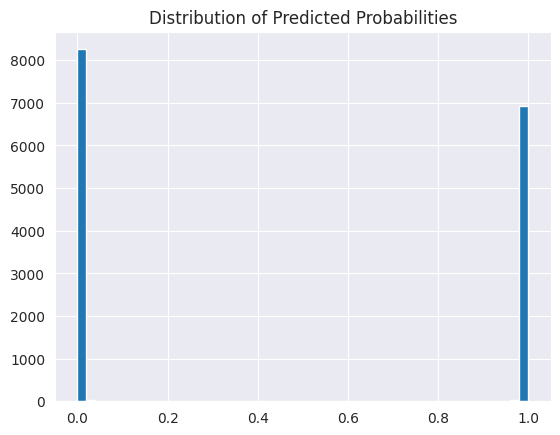

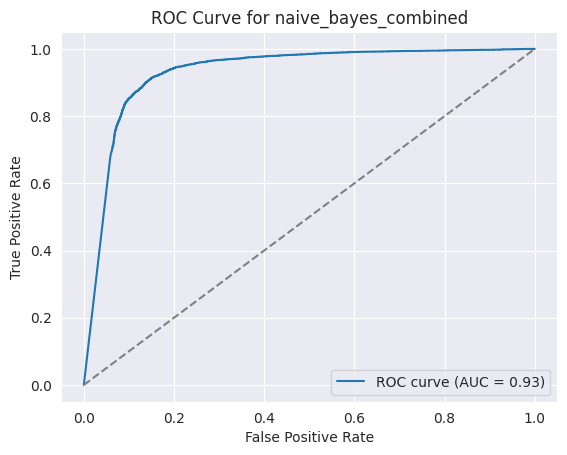

ROC curve saved as 'naive_bayes_combined_roc_curve.png'
Metrics for naive_bayes_combined saved as 'naive_bayes_combined_metrics.csv'
Evaluating naive_bayes_combined_on_human on test data...
Results for naive_bayes_combined_on_human:
Accuracy: 0.82
Precision: 0.81
Recall: 0.83
F1 Score: 0.82
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2538, 2640]))


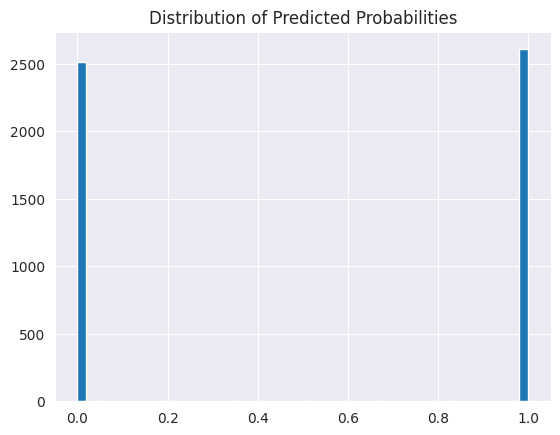

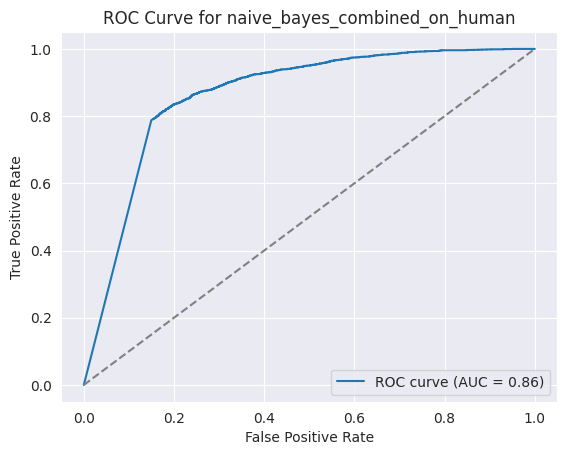

ROC curve saved as 'naive_bayes_combined_on_human_roc_curve.png'
Metrics for naive_bayes_combined_on_human saved as 'naive_bayes_combined_on_human_metrics.csv'
Evaluating naive_bayes_combined_on_thaliana on test data...
Results for naive_bayes_combined_on_thaliana:
Accuracy: 0.89
Precision: 0.96
Recall: 0.82
F1 Score: 0.89
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([2942, 2236]))


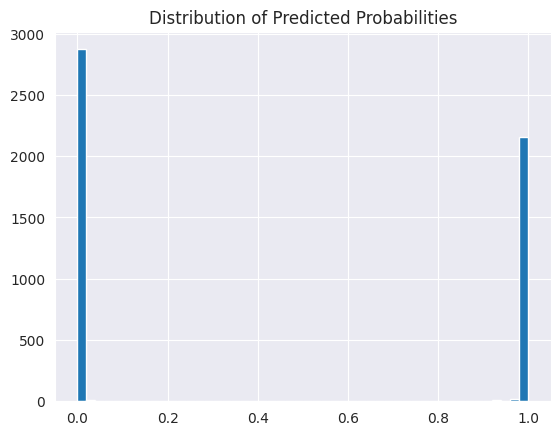

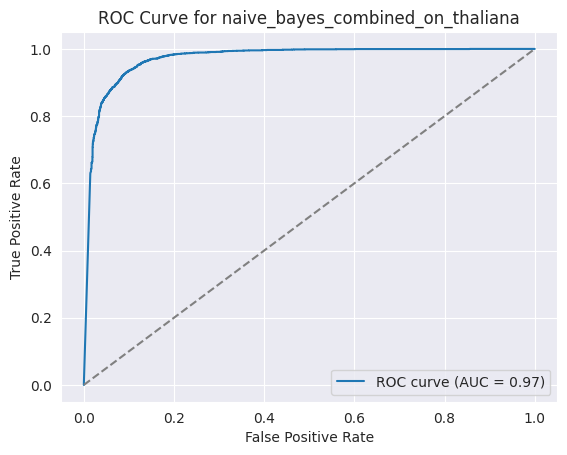

ROC curve saved as 'naive_bayes_combined_on_thaliana_roc_curve.png'
Metrics for naive_bayes_combined_on_thaliana saved as 'naive_bayes_combined_on_thaliana_metrics.csv'
Evaluating naive_bayes_combined_on_mouse on test data...
Results for naive_bayes_combined_on_mouse:
Accuracy: 0.90
Precision: 0.96
Recall: 0.83
F1 Score: 0.89
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([2945, 2233]))


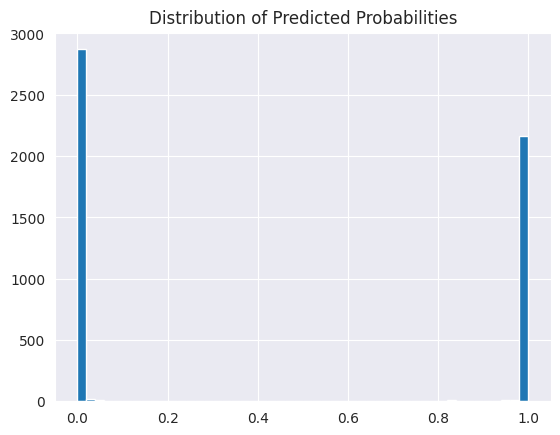

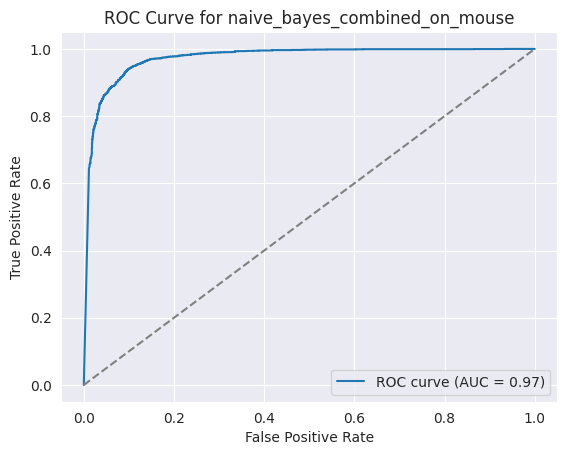

ROC curve saved as 'naive_bayes_combined_on_mouse_roc_curve.png'
Metrics for naive_bayes_combined_on_mouse saved as 'naive_bayes_combined_on_mouse_metrics.csv'


In [43]:
# evaluating the model on combined test data, human, thaliana, and mouse
x_test = train_test_splits['Combined']['x_test']
y_test = train_test_splits['Combined']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_combined')
x_test = train_test_splits['Human']['x_test']
y_test = train_test_splits['Human']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_combined_on_human')
x_test = train_test_splits['Thaliana']['x_test']
y_test = train_test_splits['Thaliana']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_combined_on_thaliana')
x_test = train_test_splits['Mouse']['x_test']
y_test = train_test_splits['Mouse']['y_test']
nb_metrics, nb_y_pred, nb_y_prob = evaluate_model(best_nb_model, x_test, y_test, 'naive_bayes_combined_on_mouse')

### Implementing a Random Forest model via gridsearch, Training on Human

In [ ]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'kmer__K': [4, 6, 8, 10,],  # Different k-mer sizes
    'model__n_estimators': [50, 100, 200],  # Number of trees
    'model__max_depth': [10, 20, 50, 100],  # Maximum depth of the trees
    'model__min_samples_split': [2],  # Minimum samples required to split an internal node
}

# Perform grid search with logging
X_train = train_test_splits['Human']['x_train']
y_train = train_test_splits['Human']['y_train']
best_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train=X_train['Sequence'].values,
    y_train=y_train,
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy'
)

In [ ]:
# evaluating the model on human, thaliana, and mouse test data
evaluate_model(best_rf_model, train_test_splits['Human']['x_test'], train_test_splits['Human']['y_test'], 'random_forest_human')
evaluate_model(best_rf_model, train_test_splits['Thaliana']['x_test'], train_test_splits['Thaliana']['y_test'], 'random_forest_human_on_thaliana')
evaluate_model(best_rf_model, train_test_splits['Mouse']['x_test'], train_test_splits['Mouse']['y_test'], 'random_forest_human_on_mouse')


### Training Random Forest on Combined Data

In [ ]:
# training Random Forest model on combined data
best_rf_model, best_rf_params, best_rf_score = gridsearch_with_logging(
    X_train=train_test_splits['Combined']['x_train'],
    y_train=train_test_splits['Combined']['y_train'],
    model=model,
    param_grid=param_grid,
    model_name='random_forest',
    cv=5,
    scoring='accuracy'
)

In [ ]:
# evaluating the model on combined data, human, thaliana, and mouse
evaluate_model(best_rf_model, train_test_splits['Combined']['x_test'], train_test_splits['Combined']['y_test'], 'random_forest_combined')
evaluate_model(best_rf_model, train_test_splits['Human']['x_test'], train_test_splits['Human']['y_test'], 'random_forest_combined_on_human')
evaluate_model(best_rf_model, train_test_splits['Thaliana']['x_test'], train_test_splits['Thaliana']['y_test'], 'random_forest_combined_on_thaliana')
evaluate_model(best_rf_model, train_test_splits['Mouse']['x_test'], train_test_splits['Mouse']['y_test'], 'random_forest_combined_on_mouse')

## Implementing a SVM model via gridsearch, Training on Human, using TruncatedSVD to reduce dimensionality


In [ ]:
svd_pipeline = Pipeline([
    ('kmer', KmerVectorizer(K=10)),
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD(n_components=10))
])
full_data_reduced = svd_pipeline.fit_transform(human['Sequence'].values)
reduced_x_train = svd_pipeline.transform(train_test_splits['Human']['x_train'])

In [ ]:
# training SVM model
from sklearn.svm import SVC
model = SVC(probability=True)
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'rbf'],
}

best_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
    X_train=reduced_x_train,
    y_train=train_test_splits['Human']['y_train'],
    model=model,
    param_grid=param_grid,
    model_name='svm',
    cv=5,
    scoring='accuracy',
    transform=False
)

### Evaluating SVM model on Human, Thaliana, and Mouse


In [ ]:
# evaluating the model on human, thaliana, and mouse test data
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Human']['x_test']), train_test_splits['Human']['y_test'], 'svm_human')
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Thaliana']['x_test']), train_test_splits['Thaliana']['y_test'], 'svm_human_on_thaliana')
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Mouse']['x_test']), train_test_splits['Mouse']['y_test'], 'svm_human_on_mouse')

### Training SVM on Combined Data

In [ ]:
# training SVM model on combined data
svd_pipeline.fit_transform(combined_data['Sequence'].values)
best_svm_model, best_svm_params, best_svm_score = gridsearch_with_logging(
    X_train=svd_pipeline.transform(train_test_splits['Combined']['x_train']),
    y_train=train_test_splits['Combined']['y_train'],
    model=model,
    param_grid=param_grid,
    model_name='svm',
    cv=5,
    scoring='accuracy',
    transform=False
)

### Evaluating SVM model on Combined Data, Human, Thaliana, and Mouse

In [ ]:
# evaluating the model on combined data, human, thaliana, and mouse
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Combined']['x_test']), train_test_splits['Combined']['y_test'], 'svm_combined')
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Human']['x_test']), train_test_splits['Human']['y_test'], 'svm_combined_on_human')
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Thaliana']['x_test']), train_test_splits['Thaliana']['y_test'], 'svm_combined_on_thaliana')
evaluate_model(best_svm_model, svd_pipeline.transform(train_test_splits['Mouse']['x_test']), train_test_splits['Mouse']['y_test'], 'svm_combined_on_mouse')


# Implementing a simple MLP model, with using keras

In [111]:
# Creating a mutation layer

def create_kmer_model_with_transform(X_train_sequences, k=4, hidden_nodes=256, dropout_rate=0.2):
    # Convert the sequences to tf.string tensors
    X_train_sequences = tf.constant(X_train_sequences, dtype=tf.string)

    text_vectorization = TextVectorization(
        standardize=None,
        split='character',
        ngrams=k,
        output_mode='count',
    )
    # Adapt the layer using a tf.data.Dataset
    text_vectorization.adapt(tf.data.Dataset.from_tensor_slices(X_train_sequences).batch(32))

    # Build the model
    model = Sequential([
        text_vectorization,
        Lambda(lambda x: tf.cast(x, tf.float32)),  # Cast counts to float32
        Dense(hidden_nodes, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_nodes // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [93]:
# creating validation data for human and combined data
human_x_train = train_test_splits['Human']['x_train']
human_y_train = train_test_splits['Human']['y_train']
train_test_splits['Human']['x_train'], train_test_splits['Human']['x_val'], train_test_splits['Human']['y_train'], train_test_splits['Human']['y_val'] = train_test_split(human_x_train, human_y_train, test_size=0.2)
combined_x_train = train_test_splits['Combined']['x_train']
combined_y_train = train_test_splits['Combined']['y_train']
train_test_splits['Combined']['x_train'], train_test_splits['Combined']['x_val'], train_test_splits['Combined']['y_train'], train_test_splits['Combined']['y_val'] = train_test_split(combined_x_train, combined_y_train, test_size=0.2)


In [102]:
# creating a dictionary of the tensor datasets
project_tensors = {}
for species in train_test_splits.keys():
    project_tensors[species] = {}
    for split in ['train', 'val', 'test']:
        if f'x_{split}' in train_test_splits[species].keys():
            project_tensors[species][split] = tf.data.Dataset.from_tensor_slices((tf.constant(train_test_splits[species][f'x_{split}'], dtype=tf.string), tf.constant(train_test_splits[species][f'y_{split}'], dtype=tf.int32))).batch(32)


In [104]:
print(project_tensors['Human']['train'])

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [110]:
k_values = [4, 6, 8, 10]
kmer_models = []
kmer_model_names = []

for k in k_values:
    model_name = f'k_{k}'
    print(f"Training model {model_name}...")
    model = create_kmer_model_with_transform(human['Sequence'].values, k=k, hidden_nodes=256, dropout_rate=0.2)
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        filepath=f'{model_name}_best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
    model.fit(
        project_tensors['Human']['train'],
        epochs=20,
        validation_data=project_tensors['Human']['val'],
        callbacks=[early_stopping, lr_scheduler, model_checkpoint]
    )
    print(f"Model saved as '{model_name}_best_model.h5'")
    kmer_models.append(model)
    kmer_model_names.append(model_name)

Training model k_4...
Epoch 1/20
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
Tensor("Placeholder:0", shape=(None,), dtype=float32)
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
Tensor("sequential_11_1/Cast:0", shape=(None,), dtype=float32)


TypeError: Exception encountered when calling KmerRandomMutationLayer.call().

[1mFailed to convert elements of <DynamicRaggedShape lengths=[None, None] num_row_partitions=1> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.[0m

Arguments received by KmerRandomMutationLayer.call():
  • inputs=tf.Tensor(shape=(None,), dtype=float32)
  • training=True

### Evaluating Kmer models on Human, Thaliana, and Mouse


Evaluating model k_4...
Evaluating k_4_human on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Results for k_4_human:
Accuracy: 0.83
Precision: 0.86
Recall: 0.80
F1 Score: 0.83
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2781, 2397]))


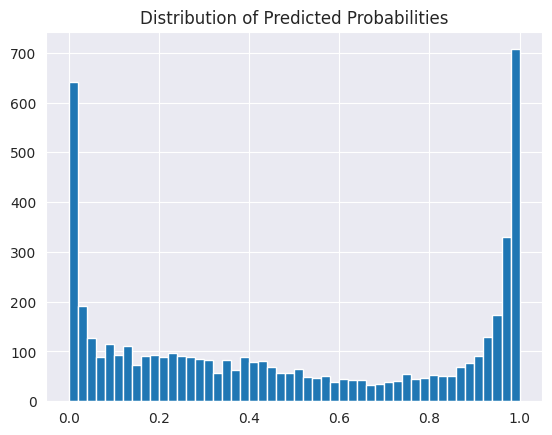

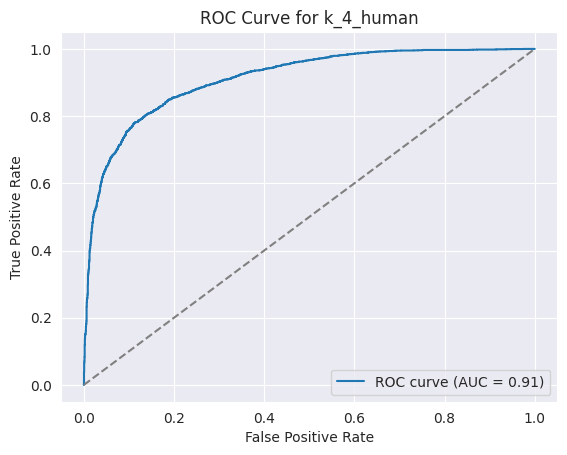

ROC curve saved as 'k_4_human_roc_curve.png'
Metrics for k_4_human saved as 'k_4_human_metrics.csv'
Evaluating k_4_human_on_thaliana on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Results for k_4_human_on_thaliana:
Accuracy: 0.51
Precision: 0.53
Recall: 0.18
F1 Score: 0.27
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([4282,  896]))


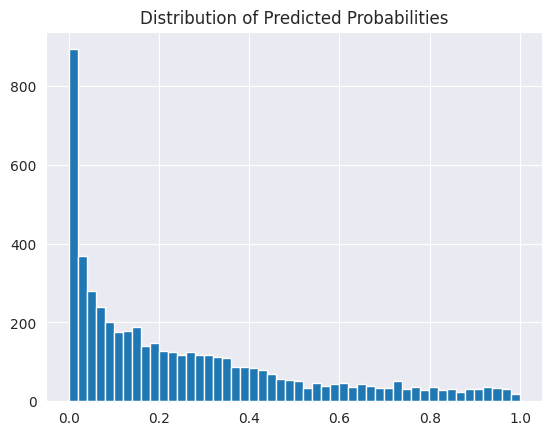

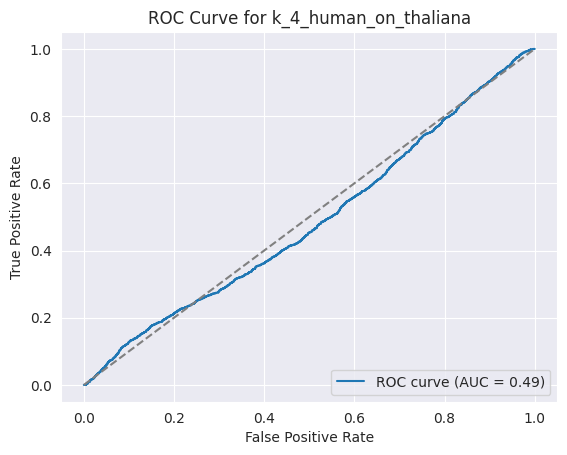

ROC curve saved as 'k_4_human_on_thaliana_roc_curve.png'
Metrics for k_4_human_on_thaliana saved as 'k_4_human_on_thaliana_metrics.csv'
Evaluating k_4_human_on_mouse on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Results for k_4_human_on_mouse:
Accuracy: 0.51
Precision: 0.53
Recall: 0.19
F1 Score: 0.28
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([4236,  942]))


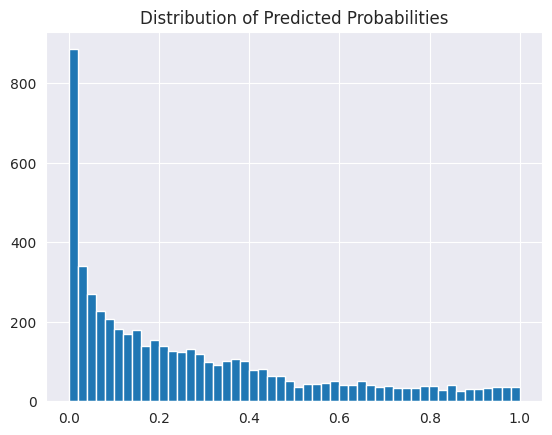

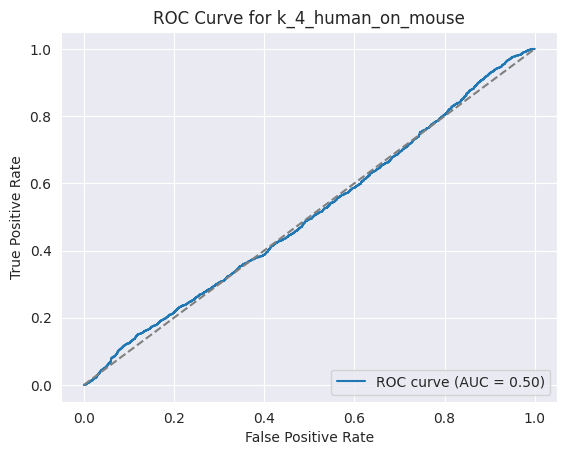

ROC curve saved as 'k_4_human_on_mouse_roc_curve.png'
Metrics for k_4_human_on_mouse saved as 'k_4_human_on_mouse_metrics.csv'
Evaluating model k_6...
Evaluating k_6_human on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Results for k_6_human:
Accuracy: 0.84
Precision: 0.85
Recall: 0.82
F1 Score: 0.83
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2696, 2482]))


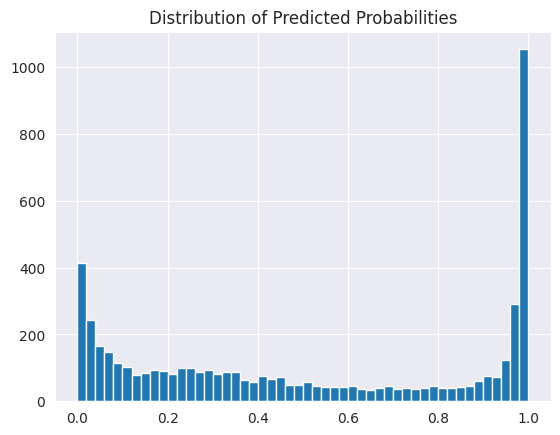

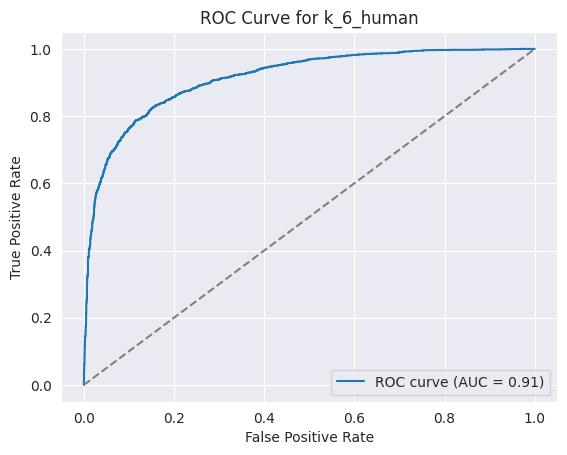

ROC curve saved as 'k_6_human_roc_curve.png'
Metrics for k_6_human saved as 'k_6_human_metrics.csv'
Evaluating k_6_human_on_thaliana on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
Results for k_6_human_on_thaliana:
Accuracy: 0.51
Precision: 0.54
Recall: 0.22
F1 Score: 0.31
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([4141, 1037]))


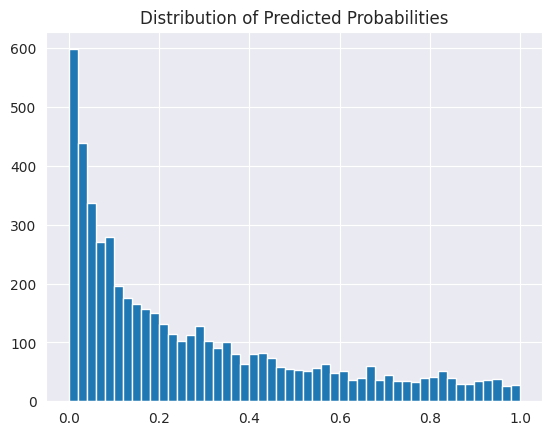

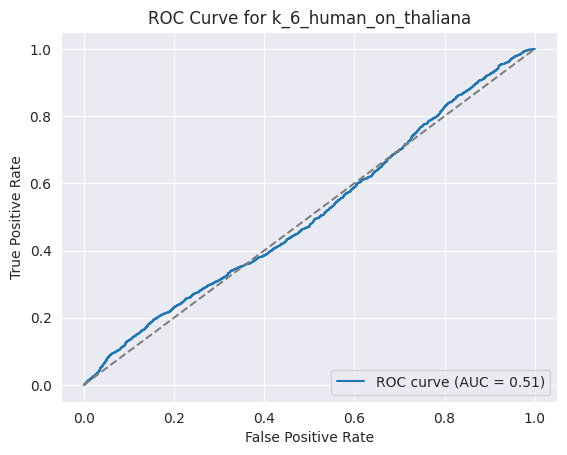

ROC curve saved as 'k_6_human_on_thaliana_roc_curve.png'
Metrics for k_6_human_on_thaliana saved as 'k_6_human_on_thaliana_metrics.csv'
Evaluating k_6_human_on_mouse on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
Results for k_6_human_on_mouse:
Accuracy: 0.53
Precision: 0.56
Recall: 0.24
F1 Score: 0.34
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([4075, 1103]))


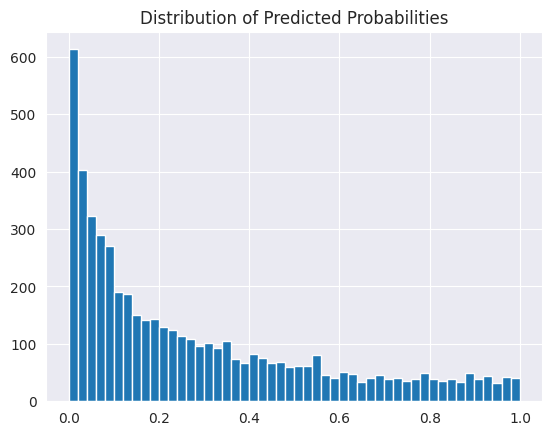

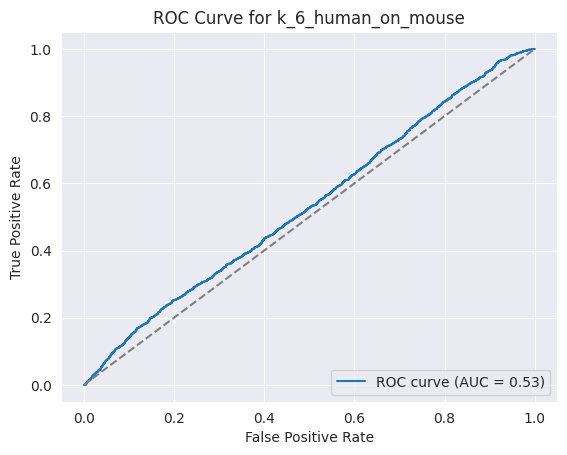

ROC curve saved as 'k_6_human_on_mouse_roc_curve.png'
Metrics for k_6_human_on_mouse saved as 'k_6_human_on_mouse_metrics.csv'
Evaluating model k_8...
Evaluating k_8_human on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step
Results for k_8_human:
Accuracy: 0.84
Precision: 0.86
Recall: 0.82
F1 Score: 0.84
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2719, 2459]))


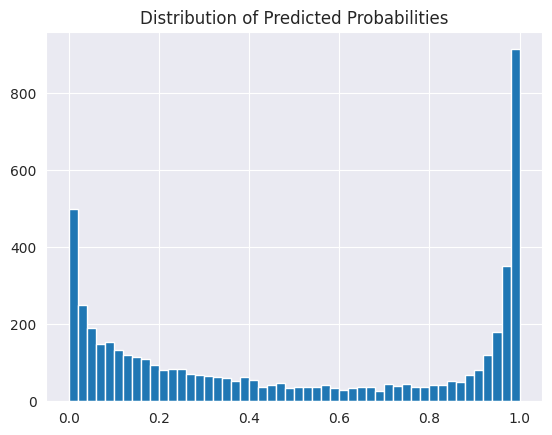

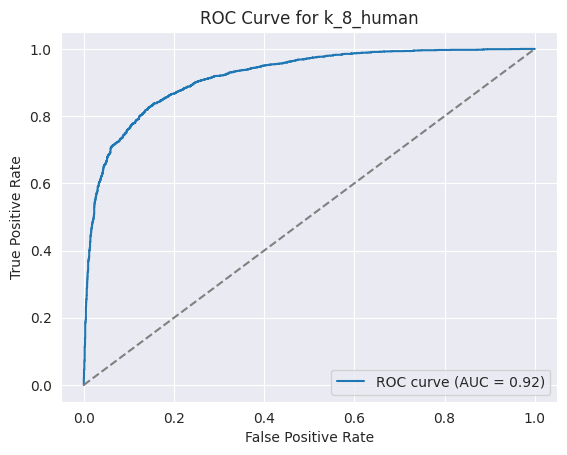

ROC curve saved as 'k_8_human_roc_curve.png'
Metrics for k_8_human saved as 'k_8_human_metrics.csv'
Evaluating k_8_human_on_thaliana on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step
Results for k_8_human_on_thaliana:
Accuracy: 0.52
Precision: 0.57
Recall: 0.19
F1 Score: 0.28
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([4322,  856]))


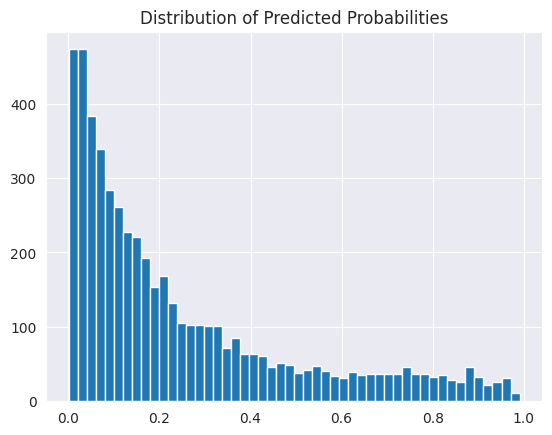

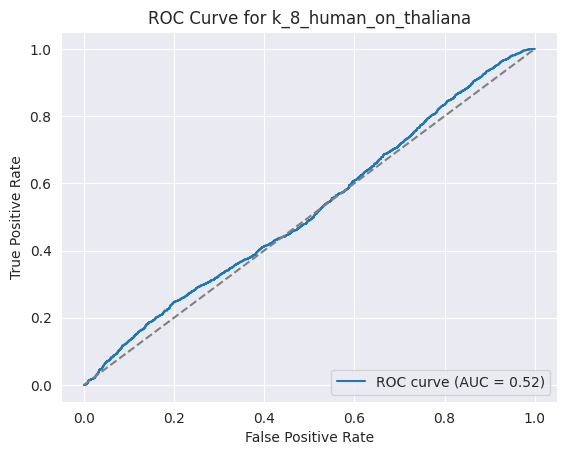

ROC curve saved as 'k_8_human_on_thaliana_roc_curve.png'
Metrics for k_8_human_on_thaliana saved as 'k_8_human_on_thaliana_metrics.csv'
Evaluating k_8_human_on_mouse on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step
Results for k_8_human_on_mouse:
Accuracy: 0.52
Precision: 0.56
Recall: 0.20
F1 Score: 0.30
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([4249,  929]))


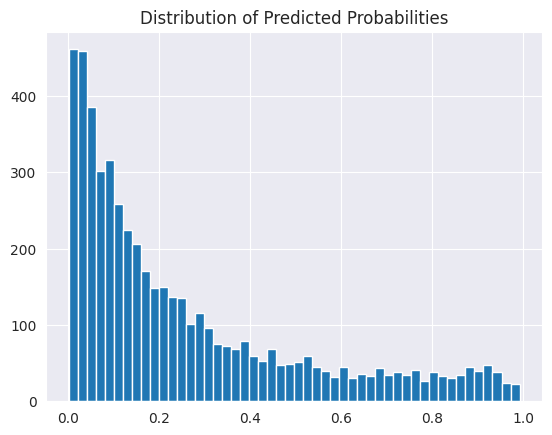

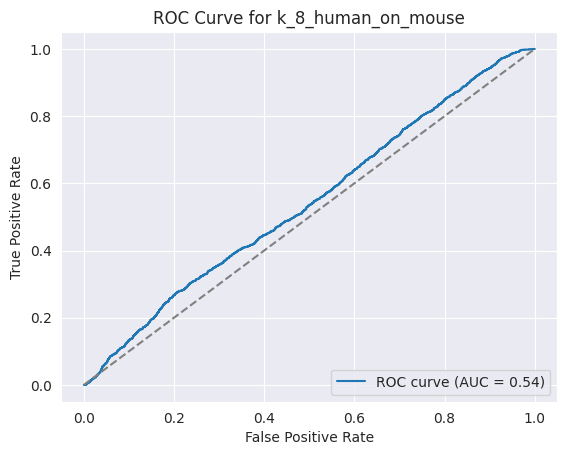

ROC curve saved as 'k_8_human_on_mouse_roc_curve.png'
Metrics for k_8_human_on_mouse saved as 'k_8_human_on_mouse_metrics.csv'
Evaluating model k_10...
Evaluating k_10_human on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step
Results for k_10_human:
Accuracy: 0.84
Precision: 0.89
Recall: 0.77
F1 Score: 0.82
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2948, 2230]))


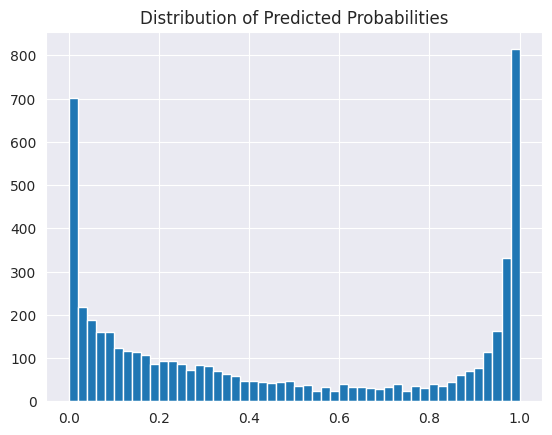

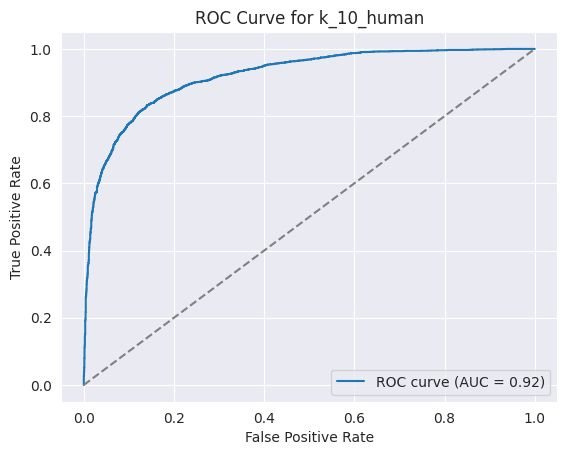

ROC curve saved as 'k_10_human_roc_curve.png'
Metrics for k_10_human saved as 'k_10_human_metrics.csv'
Evaluating k_10_human_on_thaliana on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step
Results for k_10_human_on_thaliana:
Accuracy: 0.54
Precision: 0.62
Recall: 0.23
F1 Score: 0.34
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([4209,  969]))


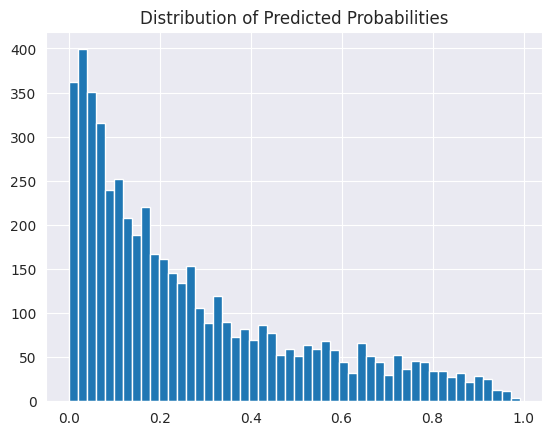

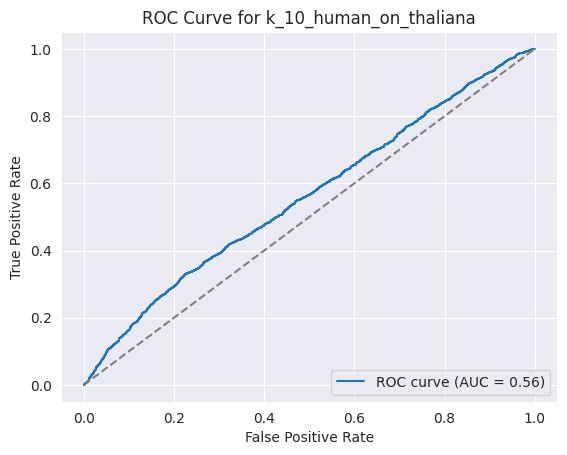

ROC curve saved as 'k_10_human_on_thaliana_roc_curve.png'
Metrics for k_10_human_on_thaliana saved as 'k_10_human_on_thaliana_metrics.csv'
Evaluating k_10_human_on_mouse on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step
Results for k_10_human_on_mouse:
Accuracy: 0.55
Precision: 0.63
Recall: 0.25
F1 Score: 0.36
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([4136, 1042]))


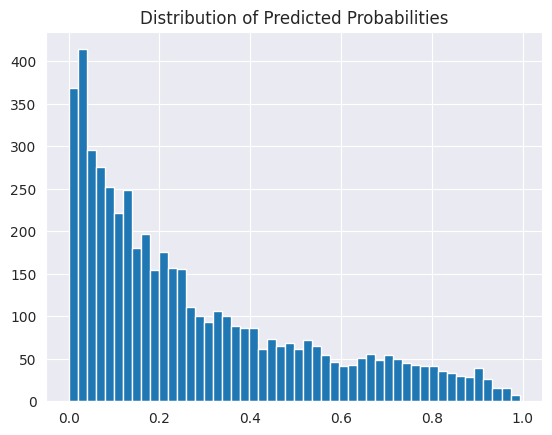

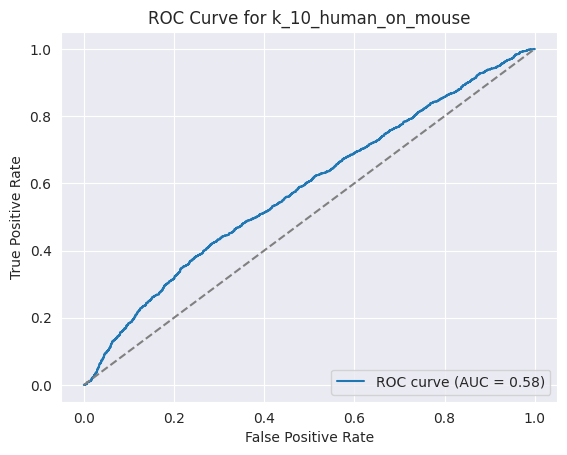

ROC curve saved as 'k_10_human_on_mouse_roc_curve.png'
Metrics for k_10_human_on_mouse saved as 'k_10_human_on_mouse_metrics.csv'


In [55]:
# Evaluate the models on the test sets
for model, model_name in zip(kmer_models, kmer_model_names):
    print(f"Evaluating model {model_name}...")
    evaluate_model(model, train_test_splits['Human']['x_test'], train_test_splits['Human']['y_test'], model_name+'_human')
    evaluate_model(model, train_test_splits['Thaliana']['x_test'], train_test_splits['Thaliana']['y_test'], model_name+'_human_on_thaliana')
    evaluate_model(model, train_test_splits['Mouse']['x_test'], train_test_splits['Mouse']['y_test'], model_name+'_human_on_mouse')


### Training the best model on combined data


In [57]:
# training the best model on combined data
best_kmer_model = kmer_models[2]
best_kmer_model_name = kmer_model_names[2]
best_kmer_model.fit(
    project_tensors['Combined']['train'],
    epochs=20,
    validation_data=project_tensors['Combined']['val'],
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - AUC: 0.8819 - accuracy: 0.8049 - loss: 0.4297 - val_AUC: 0.9458 - val_accuracy: 0.8809 - val_loss: 0.2960 - learning_rate: 5.0000e-04
Epoch 2/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - AUC: 0.9674 - accuracy: 0.9108 - loss: 0.2292 - val_AUC: 0.9576 - val_accuracy: 0.8988 - val_loss: 0.2783 - learning_rate: 5.0000e-04
Epoch 3/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 108s 70ms/step - AUC: 0.9886 - accuracy: 0.9497 - loss: 0.1330 - val_AUC: 0.9616 - val_accuracy: 0.9069 - val_loss: 0.2931 - learning_rate: 5.0000e-04
Epoch 4/20
1553/1554 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - AUC: 0.9942 - accuracy: 0.9657 - loss: 0.0917
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 103s 66ms/step - AUC: 0.9942 - accuracy: 0.9657 - loss: 0.0917 - val_AUC: 0.9548 - val_accuracy: 0.9041 - val_loss: 0.3327 - learning_rate: 5.0000e-04
Epoch 5/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 108s 70ms/step - A

### Evaluating the best model on Combined Data, Human, Thaliana, and Mouse

In [81]:
# Evaluate the best model on the test sets
evaluate_model(best_kmer_model, train_test_splits['Combined']['x_test'], train_test_splits['Combined']['y_test'], best_kmer_model_name+'_combined')
evaluate_model(best_kmer_model, train_test_splits['Human']['x_test'], train_test_splits['Human']['y_test'], best_kmer_model_name+'_combined_on_human')
evaluate_model(best_kmer_model, train_test_splits['Thaliana']['x_test'], train_test_splits['Thaliana']['y_test'], best_kmer_model_name+'_combined_on_thaliana')
evaluate_model(best_kmer_model, train_test_splits['Mouse']['x_test'], train_test_splits['Mouse']['y_test'], best_kmer_model_name+'_combined_on_mouse')

Evaluating k_8_combined on test data...
168/486 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step

KeyboardInterrupt: 

## Implementing a more advanced Transformer based model using keras

In [74]:
# DNA Tokenization Function
def dna_tokenizer(sequence, vocab={'A': 1, 'C': 2, 'G': 3, 'T': 4,'N':5}, max_length=None):
    tokens = [vocab.get(nuc, 0) for nuc in sequence]  # Map nucleotides to integers
    if max_length:
        tokens = tokens[:max_length] + [0] * max(0, max_length - len(tokens))  # Pad to max_length
    return tokens

def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.5):
    # setup content and positional bias weights of dimension [num_heads, embed_dim]
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    attention_output = attention_layer(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # MLP
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(embed_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(ff_output + attention_output)

    return sequence_output

# implementing a mutation layer to avoid overfitting

class RandomMutationLayer(Layer):
    def __init__(self, mutation_rate=0.05, vocab_size=5, **kwargs):
        super(RandomMutationLayer, self).__init__(**kwargs)
        self.mutation_rate = mutation_rate
        self.vocab_size = vocab_size  # Include 0 for padding and 1-4 for nucleotides

    def call(self, inputs, training=None):
        if not training:
            return inputs  # No mutations during inference
        mutation_mask = tf.random.uniform(shape=tf.shape(inputs)) < self.mutation_rate
        random_mutations = tf.random.uniform(
            shape=tf.shape(inputs),
            minval=1, maxval=self.vocab_size,
            dtype=tf.int32
        )
        return tf.where(mutation_mask, random_mutations, inputs)

def create_embedding_model_with_transformer(
        max_length, vocab_size, embedding_dim=64,
):
    inputs = Input(shape=(max_length,), dtype=tf.int32)
    mutations = RandomMutationLayer(mutation_rate=0.05, vocab_size=vocab_size)(inputs)
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(mutations)
    positional_encoding = keras_hub.layers.SinePositionEncoding(max_wavelength=1000)(embedding)
    embedding = embedding + positional_encoding
    conv = Conv1D(filters=64, kernel_size=10, activation='relu', padding='same')(embedding)
    conv = MaxPooling1D(pool_size=4)(conv)
    # lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    # attention =MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(lstm, lstm)
    # adding pass through connection
    for i in range(2):
        x = transformer_block(conv, embedding_dim, 8, 256,  dropout_rate=0.5)
    # add passthrough
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    focal_loss = tf.keras.losses.BinaryFocalCrossentropy()
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy', 'AUC'])
    return model

def prepare_dna_data(data_dict, max_length):
    # Tokenize DNA sequences
    vocab = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    x_train_tokenized = data_dict['x_train'].apply(lambda seq: dna_tokenizer(seq, vocab, max_length))
    x_val_tokenized = data_dict['x_val'].apply(lambda seq: dna_tokenizer(seq, vocab, max_length))

    x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_tokenized, maxlen=max_length)
    x_val_padded = tf.keras.preprocessing.sequence.pad_sequences(x_val_tokenized, maxlen=max_length)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_padded, data_dict['y_train'])).batch(32)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val_padded, data_dict['y_val'])).batch(32)

    return train_dataset, val_dataset, max_length, len(vocab) + 1





In [76]:
# training the model on human data, with k=1
x_train, x_val, max_length, vocab_size = prepare_dna_data(train_test_splits['Human'], 350)
transformer_model = create_embedding_model_with_transformer(max_length, vocab_size, embedding_dim=64)
transformer_model.fit(x_train,  validation_data=x_val, epochs=20, callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/20


I0000 00:00:1733219645.873802   25182 service.cc:148] XLA service 0x756df80a17e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733219645.876954   25182 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1733219645.876966   25182 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1733219645.876971   25182 service.cc:156]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-03 01:54:06.017336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-03 01:54:06.100604: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. functiona

 34/518 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5130 - accuracy: 0.5212 - loss: 0.4129

I0000 00:00:1733219657.233313   25182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.6799 - accuracy: 0.6363 - loss: 0.1949

2024-12-03 01:54:33.469473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 80 bytes spill stores, 80 bytes spill loads

2024-12-03 01:54:33.496168: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 28 bytes spill stores, 28 bytes spill loads

2024-12-03 01:54:33.631658: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 72 bytes spill stores, 72 bytes spill loads

2024-12-03 01:54:33.639978: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 4 bytes spill stores, 4 bytes spill loads



518/518 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - AUC: 0.6801 - accuracy: 0.6364 - loss: 0.1949 - val_AUC: 0.8745 - val_accuracy: 0.7984 - val_loss: 0.1248 - learning_rate: 0.0010
Epoch 2/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8681 - accuracy: 0.7956 - loss: 0.1178 - val_AUC: 0.8825 - val_accuracy: 0.8015 - val_loss: 0.1205 - learning_rate: 0.0010
Epoch 3/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.8909 - accuracy: 0.8156 - loss: 0.1080 - val_AUC: 0.9545 - val_accuracy: 0.8873 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 4/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9423 - accuracy: 0.8717 - loss: 0.0809 - val_AUC: 0.9590 - val_accuracy: 0.9008 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 5/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9497 - accuracy: 0.8866 - loss: 0.0758 - val_AUC: 0.9611 - val_accuracy: 0.9005 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 6/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9549 - accuracy: 0.8913 - lo

### Evaluating the Transformer model on Human, Thaliana, and Mouse


Evaluating transformer_human on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Results for transformer_human:
Accuracy: 0.90
Precision: 0.90
Recall: 0.91
F1 Score: 0.90
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2580, 2598]))


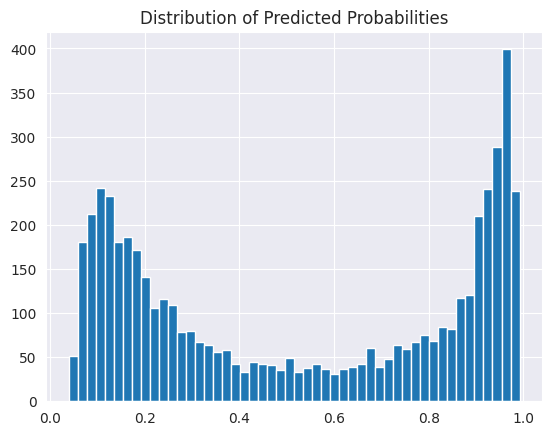

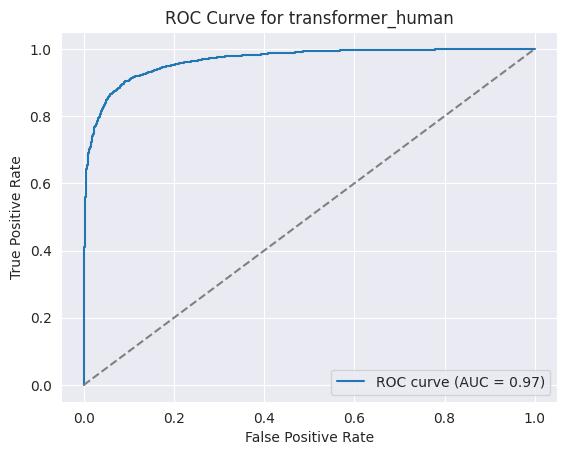

ROC curve saved as 'transformer_human_roc_curve.png'
Metrics for transformer_human saved as 'transformer_human_metrics.csv'
Evaluating transformer_human_on_thaliana on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for transformer_human_on_thaliana:
Accuracy: 0.68
Precision: 0.91
Recall: 0.40
F1 Score: 0.56
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([4026, 1152]))


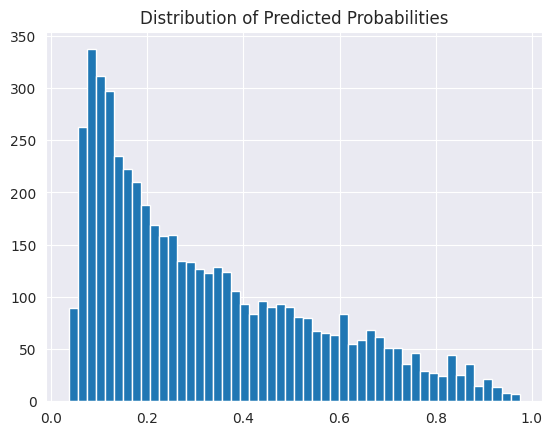

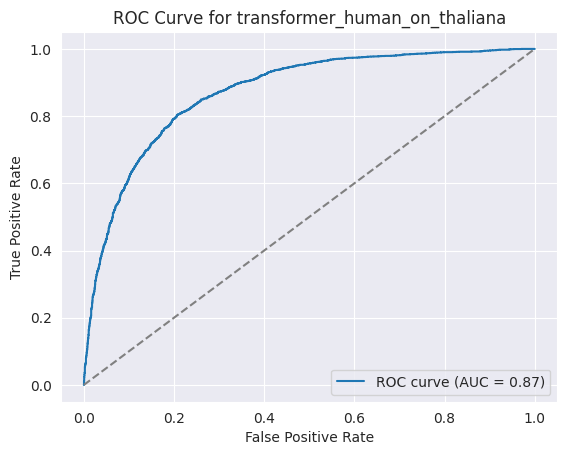

ROC curve saved as 'transformer_human_on_thaliana_roc_curve.png'
Metrics for transformer_human_on_thaliana saved as 'transformer_human_on_thaliana_metrics.csv'
Evaluating transformer_human_on_mouse on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for transformer_human_on_mouse:
Accuracy: 0.69
Precision: 0.91
Recall: 0.42
F1 Score: 0.58
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([3977, 1201]))


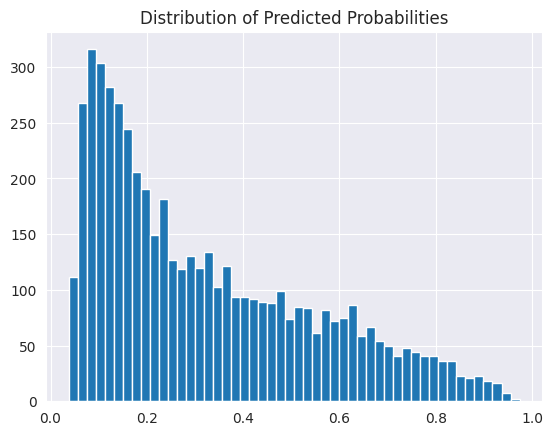

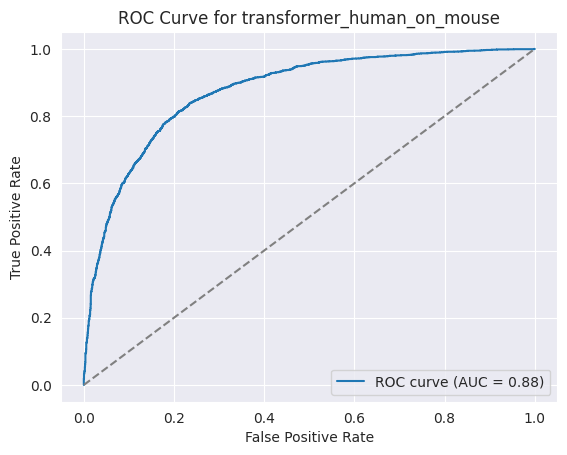

ROC curve saved as 'transformer_human_on_mouse_roc_curve.png'
Metrics for transformer_human_on_mouse saved as 'transformer_human_on_mouse_metrics.csv'


({'accuracy': 0.6896485129393588,
  'precision': np.float64(0.9117402164862615),
  'recall': np.float64(0.42180277349768874),
  'f1': np.float64(0.5767711351066631),
  'roc_auc': np.float64(0.8755238053180785)},
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0.23288041, 0.15077472, 0.14192183, ..., 0.33767253, 0.11534235,
        0.21360838]))

In [87]:
# Evaluate the model on the test sets
evaluate_model(transformer_model, train_test_splits['Human']['x_test'], train_test_splits['Human']['y_test'], 'transformer_human', max_length=max_length, attention=True)
evaluate_model(transformer_model, train_test_splits['Thaliana']['x_test'], train_test_splits['Thaliana']['y_test'], 'transformer_human_on_thaliana', max_length=max_length, attention=True)
evaluate_model(transformer_model, train_test_splits['Mouse']['x_test'], train_test_splits['Mouse']['y_test'], 'transformer_human_on_mouse', max_length=max_length, attention=True)


In [88]:
# training the model on combined data
x_train, x_val, max_length, vocab_size = prepare_dna_data(train_test_splits['Combined'], 350)
combined_transformer_model = create_embedding_model_with_transformer(max_length, vocab_size, embedding_dim=64)
combined_transformer_model.fit(x_train,  validation_data=x_val, epochs=20, callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - AUC: 0.6469 - accuracy: 0.6010 - loss: 0.1774 - val_AUC: 0.9600 - val_accuracy: 0.8910 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 2/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.9443 - accuracy: 0.8784 - loss: 0.0797 - val_AUC: 0.9694 - val_accuracy: 0.8885 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 3/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.9598 - accuracy: 0.8971 - loss: 0.0678 - val_AUC: 0.9760 - val_accuracy: 0.9119 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 4/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.9640 - accuracy: 0.9060 - loss: 0.0641 - val_AUC: 0.9782 - val_accuracy: 0.9311 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 5/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.9679 - accuracy: 0.9110 - loss: 0.0602 - val_AUC: 0.9788 - val_accuracy: 0.9303 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 6/20
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - AUC: 0.9698 

### Evaluating the Transformer model on Combined Data, Human, Thaliana, and Mouse

Evaluating transformer_combined on test data...
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Results for transformer_combined:
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
(array([False,  True]), array([7762, 7772]))
(array([0, 1]), array([7744, 7790]))


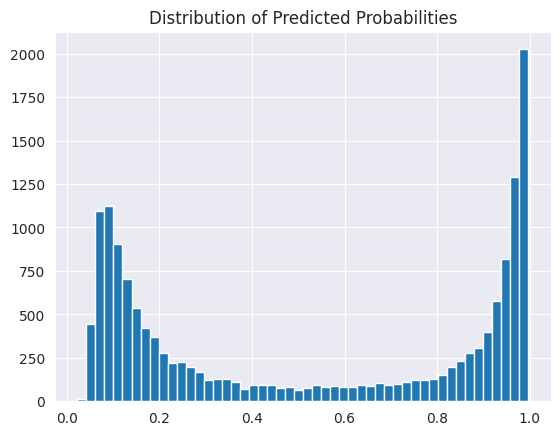

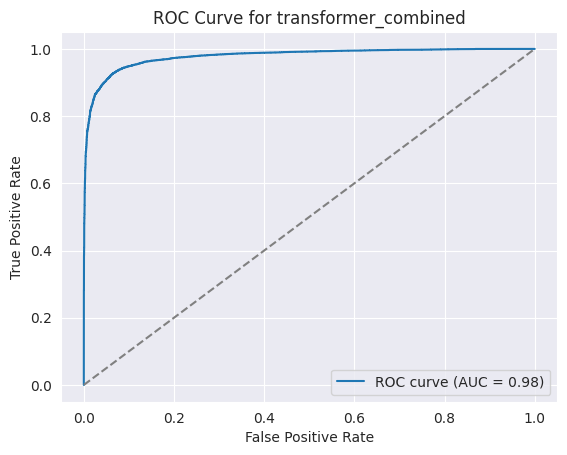

ROC curve saved as 'transformer_combined_roc_curve.png'
Metrics for transformer_combined saved as 'transformer_combined_metrics.csv'
Evaluating transformer_combined_on_human on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for transformer_combined_on_human:
Accuracy: 0.89
Precision: 0.91
Recall: 0.87
F1 Score: 0.89
(array([False,  True]), array([2604, 2574]))
(array([0, 1]), array([2700, 2478]))


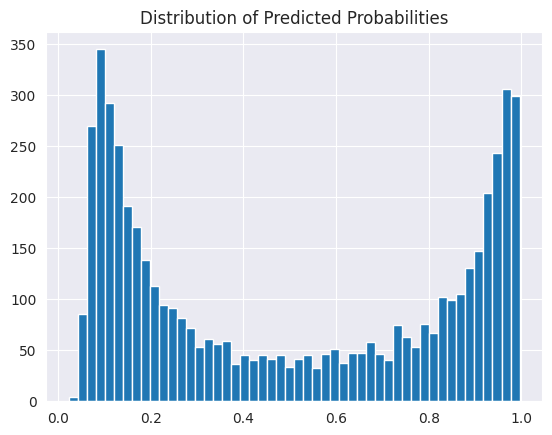

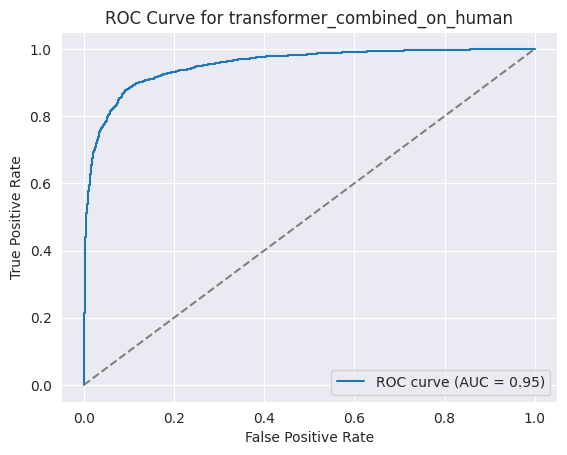

ROC curve saved as 'transformer_combined_on_human_roc_curve.png'
Metrics for transformer_combined_on_human saved as 'transformer_combined_on_human_metrics.csv'
Evaluating transformer_combined_on_thaliana on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for transformer_combined_on_thaliana:
Accuracy: 0.95
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
(array([False,  True]), array([2576, 2602]))
(array([0, 1]), array([2506, 2672]))


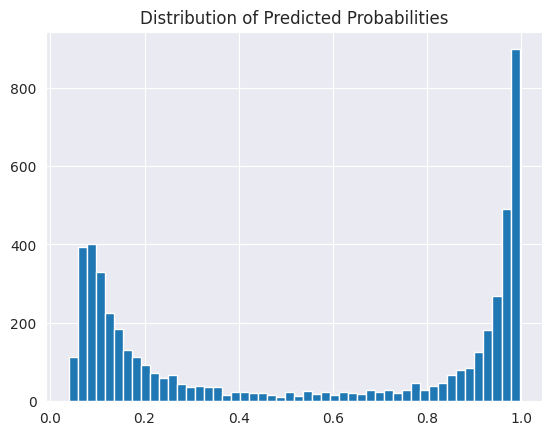

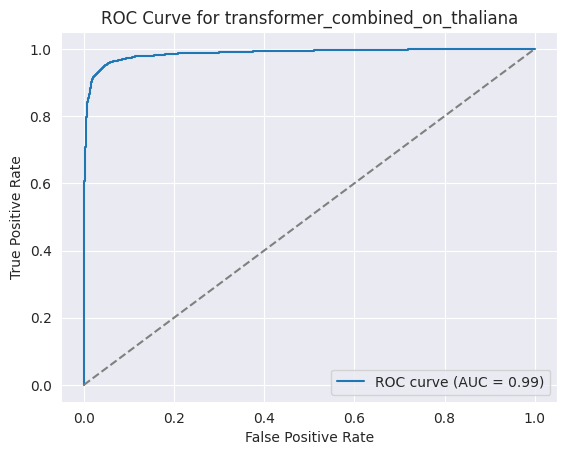

ROC curve saved as 'transformer_combined_on_thaliana_roc_curve.png'
Metrics for transformer_combined_on_thaliana saved as 'transformer_combined_on_thaliana_metrics.csv'
Evaluating transformer_combined_on_mouse on test data...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Results for transformer_combined_on_mouse:
Accuracy: 0.95
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
(array([False,  True]), array([2582, 2596]))
(array([0, 1]), array([2538, 2640]))


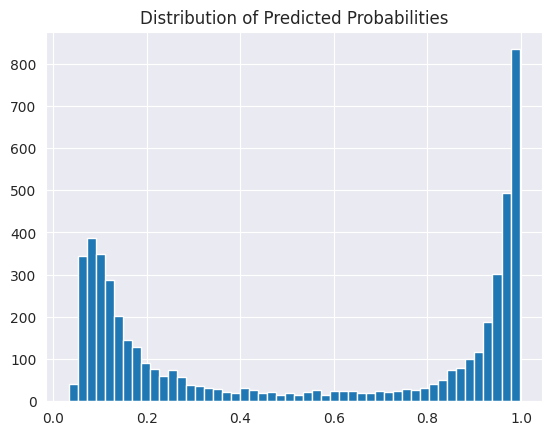

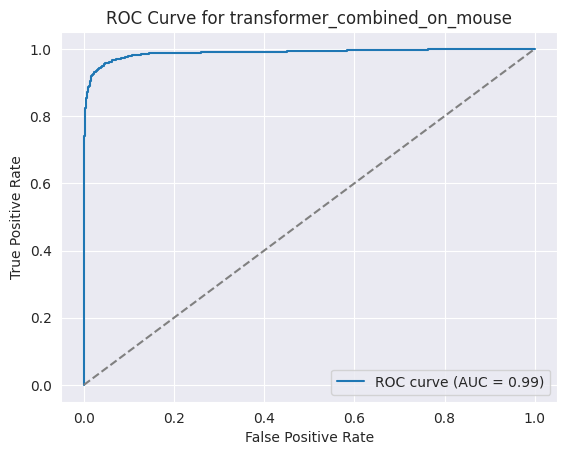

ROC curve saved as 'transformer_combined_on_mouse_roc_curve.png'
Metrics for transformer_combined_on_mouse saved as 'transformer_combined_on_mouse_metrics.csv'


({'accuracy': 0.9521050598686752,
  'precision': np.float64(0.9446969696969697),
  'recall': np.float64(0.960708782742681),
  'f1': np.float64(0.9526355996944232),
  'roc_auc': np.float64(0.9886608307603069)},
 array([1, 0, 0, ..., 1, 0, 0]),
 array([0.96583331, 0.23428541, 0.07534175, ..., 0.99187815, 0.1261811 ,
        0.12522748]))

In [90]:
# Evaluate the model on the test sets
evaluate_model(combined_transformer_model, train_test_splits['Combined']['x_test'], train_test_splits['Combined']['y_test'], 'transformer_combined', max_length=max_length, attention=True)
evaluate_model(combined_transformer_model, train_test_splits['Human']['x_test'], train_test_splits['Human']['y_test'], 'transformer_combined_on_human', max_length=max_length, attention=True)
evaluate_model(combined_transformer_model, train_test_splits['Thaliana']['x_test'], train_test_splits['Thaliana']['y_test'], 'transformer_combined_on_thaliana', max_length=max_length, attention=True)
evaluate_model(combined_transformer_model, train_test_splits['Mouse']['x_test'], train_test_splits['Mouse']['y_test'], 'transformer_combined_on_mouse', max_length=max_length, attention=True)